In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# 
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

import matplotlib.pyplot as plt

## Download dataset

In [ ]:
data_path = '/home/juangomez/Desktop/ML/Cursos/Pepe Cantoral/datasets'
num_train = 45000
batch_size = 64



transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262])
])

cifar10_train = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transform_cifar)
train_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_train)))




cifar10_val = datasets.CIFAR10(
    data_path,
    train= True,
    download=True,
    transform=transform_cifar)
val_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_train, len(cifar10_val))))


cifar10_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform= transform_cifar)
test_loader = DataLoader(
    cifar10_test,
    batch_size=batch_size,
)


In [9]:
print(num_train, len(cifar10_train))

45000 50000


In [10]:
# this make a generator
data_iter = iter(train_loader)
# get the first batch
images, labels = next(data_iter)
print(images.shape)

torch.Size([64, 3, 32, 32])


## Device

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## Show images

Show the image 0 of the batch 48. Class: 


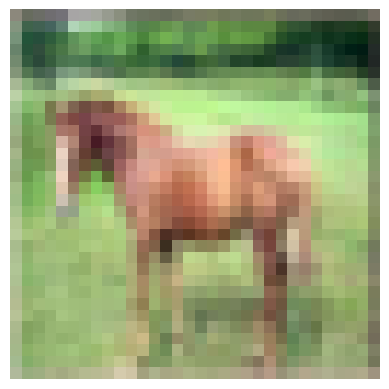

In [12]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

idx= np.random.randint(len(test_loader))
print(f'Show the image 0 of the batch {idx}. Class: ')
image = test_loader.dataset[idx][0]
image = (image- image.min())/(image.max()-image.min())
plot_figure(image)

# Accuracy

In [17]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device)
            yi = yi.to(device)
            scores = model(xi)
            # Compute the max in each row for each image of the batch
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_total += len(yi)
        return float(num_correct) / num_total

# Training Loop

In [14]:
def train(model, optimizer, epochs=100):
    model = model.to(device = device)
    for epoch in range(epochs):
        model.train()
        for (xi, yi) in train_loader:
            xi = xi.to(device = device, dtype=torch.float32)
            yi = yi.to(device = device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input=scores, target=yi.squeeze())

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        acc = accuracy(model, val_loader)
        if epoch%5 == 0:
            print(f'Epoch {epoch}, Cost: {cost.item()}, accuracy: {acc}')


# Model

In [15]:
hidden1 = 256
hidden2 = 256
lr = 5e-4
epochs = 20
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3*32*32, out_features=hidden1),
    nn.ReLU(),
    nn.Linear(in_features=hidden1, out_features=hidden2),
    nn.ReLU(),
    nn.Linear(in_features=hidden2, out_features=10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas= (0.9, 0.999))
train(model, optimizer, epochs=epochs)

Epoch 0, Cost: 1.7531592845916748, accuracy: 0.4658
Epoch 5, Cost: 1.4468587636947632, accuracy: 0.5304
Epoch 10, Cost: 0.5307830572128296, accuracy: 0.5418
Epoch 15, Cost: 0.3528009057044983, accuracy: 0.5416


In [16]:
accuracy(model, test_loader)

0.5178